In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import numpy as np
from PIL import Image
# import polars as pd
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import timeit
from tqdm import tqdm
from vit.model import ViT

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 512
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
USE_SPECTRE=True
SPECTRE_THRESHOLD=1.0

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [4]:
# Test ViT
# model = ViT(IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
model = ViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
            num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
            num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
            use_spectre=USE_SPECTRE, spectre_threshold=SPECTRE_THRESHOLD).to(device)
# Print model params number
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

103202


/home/biblbrox/Phd/experiments/SpectralViT/vit/model.py:223: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


In [5]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission_df = pd.read_csv("./data/sample_submission.csv")

In [6]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [10]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        
        image = self.transofrm(image)
        
        return {'image': image, 'label': label, 'index': index}
    

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        
        image = self.transofrm(image)
        
        return {'image': image, 'label': label, 'index': index}
       
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        super().__init__()
        self.images = images
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transofrm(image)
        
        return {'image': image, 'index': index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

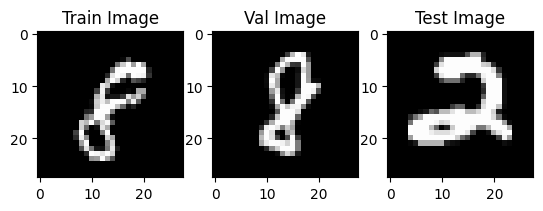

In [11]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title("Test Image")
print("-"*30)

In [12]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
use_amp = True

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
            
    
        val_loss = val_running_loss /  (idx + 1)
    
        print("-"*30)
        print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Val Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Train Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
        print(f"Val Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
        print("-"*30)

    
stop = timeit.default_timer()
print(f"Training time: {stop - start:.2f}")

  2%|▎         | 1/40 [00:07<05:10,  7.96s/it]

------------------------------
Train Loss EPOCH 1: 2.2467
Val Loss EPOCH 1: 1.9276
Train Accuracy EPOCH 1: 0.1949
Val Accuracy EPOCH 1: 0.3550
------------------------------


  5%|▌         | 2/40 [00:15<04:59,  7.88s/it]

------------------------------
Train Loss EPOCH 2: 1.7978
Val Loss EPOCH 2: 1.6510
Train Accuracy EPOCH 2: 0.4143
Val Accuracy EPOCH 2: 0.4957
------------------------------


  8%|▊         | 3/40 [00:24<05:05,  8.26s/it]

------------------------------
Train Loss EPOCH 3: 1.5987
Val Loss EPOCH 3: 1.4819
Train Accuracy EPOCH 3: 0.5305
Val Accuracy EPOCH 3: 0.6160
------------------------------


 10%|█         | 4/40 [00:32<04:49,  8.05s/it]

------------------------------
Train Loss EPOCH 4: 1.4570
Val Loss EPOCH 4: 1.3626
Train Accuracy EPOCH 4: 0.6192
Val Accuracy EPOCH 4: 0.6781
------------------------------


 12%|█▎        | 5/40 [00:39<04:36,  7.89s/it]

------------------------------
Train Loss EPOCH 5: 1.3400
Val Loss EPOCH 5: 1.2455
Train Accuracy EPOCH 5: 0.6767
Val Accuracy EPOCH 5: 0.7331
------------------------------


 15%|█▌        | 6/40 [00:47<04:25,  7.80s/it]

------------------------------
Train Loss EPOCH 6: 1.2439
Val Loss EPOCH 6: 1.1561
Train Accuracy EPOCH 6: 0.7250
Val Accuracy EPOCH 6: 0.7752
------------------------------


 18%|█▊        | 7/40 [00:55<04:17,  7.80s/it]

------------------------------
Train Loss EPOCH 7: 1.1549
Val Loss EPOCH 7: 1.0766
Train Accuracy EPOCH 7: 0.7640
Val Accuracy EPOCH 7: 0.8071
------------------------------


 20%|██        | 8/40 [01:02<04:08,  7.76s/it]

------------------------------
Train Loss EPOCH 8: 1.0808
Val Loss EPOCH 8: 1.0264
Train Accuracy EPOCH 8: 0.7951
Val Accuracy EPOCH 8: 0.8145
------------------------------


 22%|██▎       | 9/40 [01:10<03:59,  7.73s/it]

------------------------------
Train Loss EPOCH 9: 1.0090
Val Loss EPOCH 9: 0.9328
Train Accuracy EPOCH 9: 0.8182
Val Accuracy EPOCH 9: 0.8471
------------------------------


 25%|██▌       | 10/40 [01:18<03:53,  7.78s/it]

------------------------------
Train Loss EPOCH 10: 0.9463
Val Loss EPOCH 10: 0.8763
Train Accuracy EPOCH 10: 0.8352
Val Accuracy EPOCH 10: 0.8610
------------------------------


 28%|██▊       | 11/40 [01:26<03:44,  7.73s/it]

------------------------------
Train Loss EPOCH 11: 0.8900
Val Loss EPOCH 11: 0.8290
Train Accuracy EPOCH 11: 0.8447
Val Accuracy EPOCH 11: 0.8705
------------------------------


 30%|███       | 12/40 [01:33<03:35,  7.70s/it]

------------------------------
Train Loss EPOCH 12: 0.8375
Val Loss EPOCH 12: 0.7607
Train Accuracy EPOCH 12: 0.8567
Val Accuracy EPOCH 12: 0.8810
------------------------------


 32%|███▎      | 13/40 [01:41<03:29,  7.75s/it]

------------------------------
Train Loss EPOCH 13: 0.7912
Val Loss EPOCH 13: 0.7320
Train Accuracy EPOCH 13: 0.8604
Val Accuracy EPOCH 13: 0.8867
------------------------------


 35%|███▌      | 14/40 [01:49<03:20,  7.72s/it]

------------------------------
Train Loss EPOCH 14: 0.7477
Val Loss EPOCH 14: 0.6895
Train Accuracy EPOCH 14: 0.8665
Val Accuracy EPOCH 14: 0.8919
------------------------------


 38%|███▊      | 15/40 [01:56<03:12,  7.69s/it]

------------------------------
Train Loss EPOCH 15: 0.7144
Val Loss EPOCH 15: 0.6597
Train Accuracy EPOCH 15: 0.8689
Val Accuracy EPOCH 15: 0.8914
------------------------------


 40%|████      | 16/40 [02:04<03:05,  7.73s/it]

------------------------------
Train Loss EPOCH 16: 0.6775
Val Loss EPOCH 16: 0.6256
Train Accuracy EPOCH 16: 0.8749
Val Accuracy EPOCH 16: 0.8960
------------------------------


 42%|████▎     | 17/40 [02:12<02:57,  7.71s/it]

------------------------------
Train Loss EPOCH 17: 0.6438
Val Loss EPOCH 17: 0.5769
Train Accuracy EPOCH 17: 0.8798
Val Accuracy EPOCH 17: 0.9031
------------------------------


 45%|████▌     | 18/40 [02:19<02:49,  7.68s/it]

------------------------------
Train Loss EPOCH 18: 0.6138
Val Loss EPOCH 18: 0.5486
Train Accuracy EPOCH 18: 0.8825
Val Accuracy EPOCH 18: 0.9076
------------------------------


 48%|████▊     | 19/40 [02:27<02:42,  7.73s/it]

------------------------------
Train Loss EPOCH 19: 0.5865
Val Loss EPOCH 19: 0.5271
Train Accuracy EPOCH 19: 0.8856
Val Accuracy EPOCH 19: 0.9095
------------------------------


 50%|█████     | 20/40 [02:35<02:34,  7.72s/it]

------------------------------
Train Loss EPOCH 20: 0.5600
Val Loss EPOCH 20: 0.5118
Train Accuracy EPOCH 20: 0.8892
Val Accuracy EPOCH 20: 0.9107
------------------------------


 52%|█████▎    | 21/40 [02:43<02:26,  7.69s/it]

------------------------------
Train Loss EPOCH 21: 0.5405
Val Loss EPOCH 21: 0.4910
Train Accuracy EPOCH 21: 0.8896
Val Accuracy EPOCH 21: 0.9129
------------------------------


 55%|█████▌    | 22/40 [02:50<02:17,  7.66s/it]

------------------------------
Train Loss EPOCH 22: 0.5174
Val Loss EPOCH 22: 0.4782
Train Accuracy EPOCH 22: 0.8947
Val Accuracy EPOCH 22: 0.9124
------------------------------


 57%|█████▊    | 23/40 [02:58<02:11,  7.73s/it]

------------------------------
Train Loss EPOCH 23: 0.4970
Val Loss EPOCH 23: 0.4513
Train Accuracy EPOCH 23: 0.8981
Val Accuracy EPOCH 23: 0.9131
------------------------------


 60%|██████    | 24/40 [03:06<02:03,  7.75s/it]

------------------------------
Train Loss EPOCH 24: 0.4847
Val Loss EPOCH 24: 0.4277
Train Accuracy EPOCH 24: 0.8949
Val Accuracy EPOCH 24: 0.9157
------------------------------


 62%|██████▎   | 25/40 [03:14<01:55,  7.73s/it]

------------------------------
Train Loss EPOCH 25: 0.4680
Val Loss EPOCH 25: 0.4113
Train Accuracy EPOCH 25: 0.8985
Val Accuracy EPOCH 25: 0.9174
------------------------------


 65%|██████▌   | 26/40 [03:22<01:49,  7.79s/it]

------------------------------
Train Loss EPOCH 26: 0.4499
Val Loss EPOCH 26: 0.3929
Train Accuracy EPOCH 26: 0.9012
Val Accuracy EPOCH 26: 0.9179
------------------------------


 68%|██████▊   | 27/40 [03:29<01:40,  7.76s/it]

------------------------------
Train Loss EPOCH 27: 0.4354
Val Loss EPOCH 27: 0.3938
Train Accuracy EPOCH 27: 0.9031
Val Accuracy EPOCH 27: 0.9193
------------------------------


 70%|███████   | 28/40 [03:37<01:32,  7.75s/it]

------------------------------
Train Loss EPOCH 28: 0.4252
Val Loss EPOCH 28: 0.3680
Train Accuracy EPOCH 28: 0.9025
Val Accuracy EPOCH 28: 0.9210
------------------------------


 72%|███████▎  | 29/40 [03:45<01:26,  7.82s/it]

------------------------------
Train Loss EPOCH 29: 0.4114
Val Loss EPOCH 29: 0.3657
Train Accuracy EPOCH 29: 0.9060
Val Accuracy EPOCH 29: 0.9243
------------------------------


 75%|███████▌  | 30/40 [03:53<01:18,  7.84s/it]

------------------------------
Train Loss EPOCH 30: 0.3955
Val Loss EPOCH 30: 0.3609
Train Accuracy EPOCH 30: 0.9066
Val Accuracy EPOCH 30: 0.9219
------------------------------


 78%|███████▊  | 31/40 [04:01<01:10,  7.85s/it]

------------------------------
Train Loss EPOCH 31: 0.3884
Val Loss EPOCH 31: 0.3363
Train Accuracy EPOCH 31: 0.9075
Val Accuracy EPOCH 31: 0.9250
------------------------------


 80%|████████  | 32/40 [04:09<01:03,  7.95s/it]

------------------------------
Train Loss EPOCH 32: 0.3789
Val Loss EPOCH 32: 0.3407
Train Accuracy EPOCH 32: 0.9083
Val Accuracy EPOCH 32: 0.9219
------------------------------


 82%|████████▎ | 33/40 [04:17<00:55,  7.87s/it]

------------------------------
Train Loss EPOCH 33: 0.3640
Val Loss EPOCH 33: 0.3109
Train Accuracy EPOCH 33: 0.9120
Val Accuracy EPOCH 33: 0.9295
------------------------------


 85%|████████▌ | 34/40 [04:24<00:46,  7.81s/it]

------------------------------
Train Loss EPOCH 34: 0.3583
Val Loss EPOCH 34: 0.3166
Train Accuracy EPOCH 34: 0.9115
Val Accuracy EPOCH 34: 0.9298
------------------------------


 88%|████████▊ | 35/40 [04:32<00:39,  7.88s/it]

------------------------------
Train Loss EPOCH 35: 0.3503
Val Loss EPOCH 35: 0.3129
Train Accuracy EPOCH 35: 0.9135
Val Accuracy EPOCH 35: 0.9252
------------------------------


 90%|█████████ | 36/40 [04:40<00:31,  7.83s/it]

------------------------------
Train Loss EPOCH 36: 0.3358
Val Loss EPOCH 36: 0.2936
Train Accuracy EPOCH 36: 0.9166
Val Accuracy EPOCH 36: 0.9290
------------------------------


 92%|█████████▎| 37/40 [04:48<00:23,  7.81s/it]

------------------------------
Train Loss EPOCH 37: 0.3330
Val Loss EPOCH 37: 0.2871
Train Accuracy EPOCH 37: 0.9162
Val Accuracy EPOCH 37: 0.9314
------------------------------


 95%|█████████▌| 38/40 [04:56<00:15,  7.92s/it]

------------------------------
Train Loss EPOCH 38: 0.3286
Val Loss EPOCH 38: 0.2891
Train Accuracy EPOCH 38: 0.9171
Val Accuracy EPOCH 38: 0.9300
------------------------------


 98%|█████████▊| 39/40 [05:04<00:07,  7.86s/it]

------------------------------
Train Loss EPOCH 39: 0.3210
Val Loss EPOCH 39: 0.2769
Train Accuracy EPOCH 39: 0.9178
Val Accuracy EPOCH 39: 0.9286
------------------------------


100%|██████████| 40/40 [05:11<00:00,  7.80s/it]

------------------------------
Train Loss EPOCH 40: 0.3121
Val Loss EPOCH 40: 0.2714
Train Accuracy EPOCH 40: 0.9189
Val Accuracy EPOCH 40: 0.9329
------------------------------
Training time: 311.93


In [ ]:
torch.cuda.empty_cache()

In [ ]:
labels = []
ids = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i) + 1 for i in sample["index"]])
        
        outputs = model(img)
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])
        

100%|██████████| 55/55 [00:02<00:00, 24.82it/s]


<Figure size 640x480 with 0 Axes>

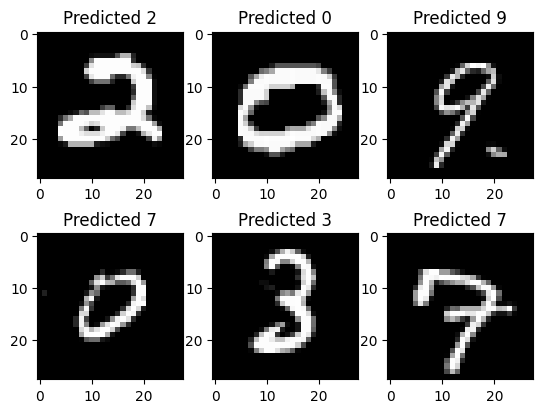

In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap='gray')
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1
        
plt.show()